# Init

In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/miniconda3/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/miniconda3/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 200
batch_size = 200
quantile_cutoff = 0.95

# MMS

In [3]:
import random
import ase.db


db_dir = '../pull_data/%s/' % adsorbate
db = ase.db.connect(db_dir + '%s.db' % adsorbate)
rows = list(db.select())
random.Random(42).shuffle(rows)


def parse_rows(rows):
    features = []
    labels = []
    surfaces = []

    for row in rows:
        features.append(row.id)
        data = row.data
        labels.append(data['adsorption_energy'])
        surface = (data['mpid'], data['miller'], data['shift'], data['top'])
        surfaces.append(surface)

    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

wandb: Wandb version 0.9.1 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


### Loading dataset: gasdb
### Loaded preprocessed data from:  ['../pull_data/CO/data.pt']
### Loading model: cgcnn
### Loaded CGCNN with 189121 parameters.
cmd:
  checkpoint_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/checkpoints/2020-06-15-17-48-23-cnn
  identifier: cnn
  logs_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/logs/2020-06-15-17-48-23-cnn
  print_every: 100
  results_dir: /global/cfs/cdirs/m2755/ktran/sandbox/2020/catalyst-acquisitions/notebooks/comparisons/results/2020-06-15-17-48-23-cnn
  seed: null
  timestamp: 2020-06-15-17-48-23-cnn
dataset:
  src: ../pull_data/CO/
  test_size: 0
  train_size: 1
  val_size: 0
logger: wandb
model: cgcnn
model_attributes:
  atom_embedding_size: 64
  fc_feat_size: 128
  num_fc_layers: 4
  num_graph_conv_layers: 6
optim:
  batch_size: 64
  lr_gamma: 0.1
  lr_initial: 0.001
  lr_milestones:
  - 25
  - 45
  max_epochs: 50
  warmup_epochs: 10
  war

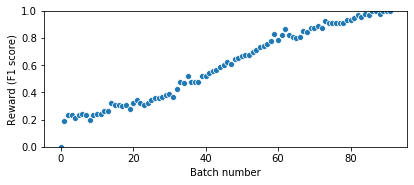

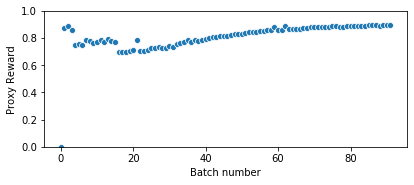

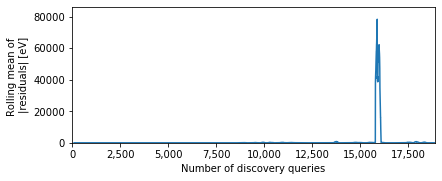

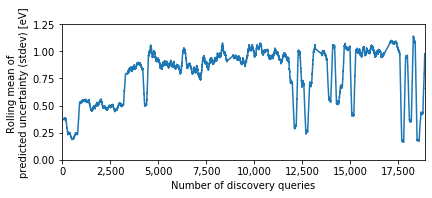

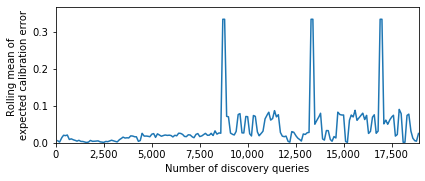

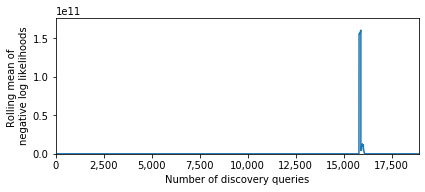

In [6]:
import sys
sys.path.insert(0, '../../')
from src.discoverers.adsorption.mms import MultiscaleDiscoverer


# Initialize
mms_discoverer = MultiscaleDiscoverer(db_dir=db_dir,
                                      target_energy=target_energy,
                                      quantile_cutoff=quantile_cutoff,
                                      batch_size=batch_size,
                                      training_features=training_features,
                                      training_labels=training_labels,
                                      training_surfaces=training_surfaces,
                                      sampling_features=sampling_features,
                                      sampling_labels=sampling_labels,
                                      sampling_surfaces=sampling_surfaces,
                                      init_train=False  # Set to `False` only for warm starts
                                     )

# Load
mms_dir = '../MMS/'
nn_cp = mms_dir + 'checkpoints/2020-06-14-10-02-26-cnn/checkpoint.pt'
gp_cp = mms_dir + 'gp_state.pth'
norm_cp = mms_dir + 'normalizer.pth'
mms_discoverer.load_last_run(nn_cp, gp_cp, norm_cp)

# Plot
mms_figs = mms_discoverer.plot_performance(window=100)

# TPOT

In [7]:
import random
import json
import numpy as np


with open('../pull_data/%s/%s.json' % (adsorbate, adsorbate), 'r') as file_handle:
    docs = json.load(file_handle)
random.Random(42).shuffle(docs)


def parse_docs(docs):
    '''
    Our testing framework needs us to divide information into features, labels, and surfaces.
    This function will convert a list of docs/dictionaries into these things.
    
    Arg:
        docs    A list of dictionaries from `gaspy.gasdb.get_adsorption_docs`
    Returns:
        features    ...just the `docs` arg
        labels      A list of the 'energy' keys in `docs`
        surfaces    A list of 4-tuples indicating the surfaces of `docs
    '''
    features = docs
    labels = [doc['energy'] for doc in docs]
    surfaces = [(doc['mpid'], doc['miller'], doc['shift'], doc['top']) for doc in docs]
    return features, labels, surfaces


training_features, training_labels, training_surfaces = parse_docs(docs[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_docs(docs[initial_training_size:])

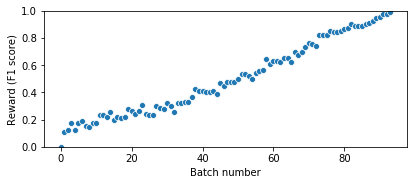

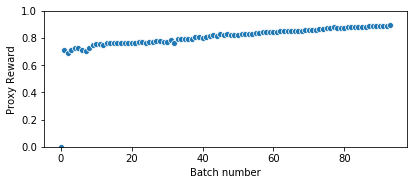

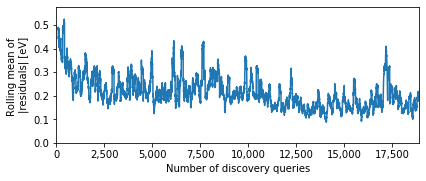

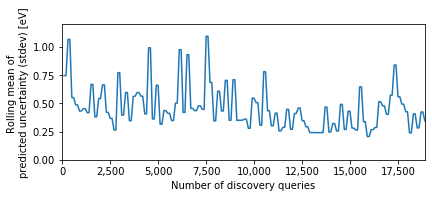

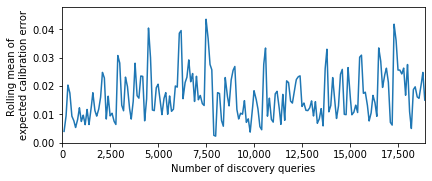

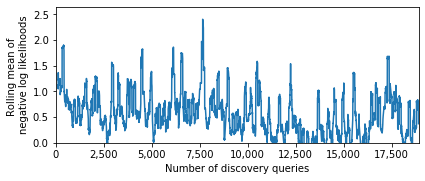

In [10]:
import warnings
import sys
sys.path.append('../..')
from src.discoverers.adsorption.tpotheuristic import TpotHeuristic


# The GASpy fingerprinter will be yelling at us a lot about missing data.
# Good to know in production, but also good to ignore here.
with warnings.catch_warnings():
    warnings.filterwarnings(message='We do not have any energy data for %s on ' % adsorbate, action='ignore')

    # Initialize
    tpot_discoverer = TpotHeuristic(target_energy=target_energy,
                                    quantile_cutoff=quantile_cutoff,
                                    batch_size=batch_size,
                                    training_features=training_features,
                                    training_labels=training_labels,
                                    training_surfaces=training_surfaces,
                                    sampling_features=sampling_features,
                                    sampling_labels=sampling_labels,
                                    sampling_surfaces=sampling_surfaces,
                                    init_train=False  # Set to `False` only for warm starts
                                   )

# Load
tpot_discoverer.load_last_run()

# Plot
tpot_figs = tpot_discoverer.plot_performance(window=100)

# Comparison

In [11]:
def plot_reward(self, reward_name=None):
    '''
    Plot the reward vs. discovery batch number

    Returns:
        fig     The matplotlib figure object for the reward plot
    '''
    # Plot. Assume that the reward only updates per batch.
    fig = plt.figure()
    batch_numbers = list(range(len(self.reward_history)))
    ax = sns.scatterplot(batch_numbers, self.reward_history)

    # Format
    if reward_name is None:
        reward_name = 'Reward'
    _ = ax.set_xlabel('Batch number')
    _ = ax.set_ylabel(reward_name)
    _ = ax.set_ylim(0., 1.)
    _ = fig.set_size_inches(*FIG_SIZE)
    _ = ax.get_xaxis().set_major_formatter(FORMATTER)
    return fig

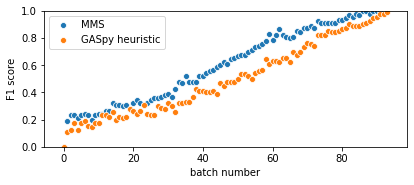

In [12]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns


FORMATTER = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
FIG_SIZE = (6.5, 2.5)


fig = plt.figure()
ax_mms = sns.scatterplot(list(range(len(mms_discoverer.reward_history))),
                         mms_discoverer.reward_history,
                         label='MMS')
ax_tpot = sns.scatterplot(list(range(len(tpot_discoverer.reward_history))),
                          tpot_discoverer.reward_history,
                          label='GASpy heuristic')

_ = ax_mms.set_xlabel('batch number')
_ = ax_mms.set_ylabel('F1 score')
_ = ax_mms.set_ylim(0., 1.)
_ = fig.set_size_inches(*FIG_SIZE)
_ = ax_mms.get_xaxis().set_major_formatter(FORMATTER)